# Data analysis for the paper "Automated Generation of Consistent Models with Structural and Attribute Constraints"

First, let's load some packages.

In [1]:
require(tidyverse)
dir.create('plots')

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in dir.create("plots"):
“'plots' already exists”


In [2]:
ProcessDetailedStatistics <- function(str) {
    str <- sub('TransformationExecutionTime', 'TransformationExecutionTime:', str)
    str <- sub('Backtrackingtime', 'BacktrackingTime', str)
    str <- gsub('\\(|\\)', '', str)
    str <- lapply(strsplit(str, '\\||:'), function (v) {
        dim(v) <- c(2, 12)
        values <- as.double(v[2,])
        names(values) <- v[1,]
        as.data.frame(t(values))
    })
    str
}
Load10Log <- function(filename, size) {
    read_csv(filename, col_types = cols(
      .default = col_double(),
      Result = col_character(),
      Solution1DetailedStatistics = col_character(),
      Solution2DetailedStatistics = col_character(),
      Solution3DetailedStatistics = col_character(),
      Solution4DetailedStatistics = col_character(),
      Solution5DetailedStatistics = col_character(),
      Solution6DetailedStatistics = col_character(),
      Solution7DetailedStatistics = col_character(),
      Solution8DetailedStatistics = col_character(),
      Solution9DetailedStatistics = col_character(),
      Solution10DetailedStatistics = col_character()
    )) %>% transmute(
        n = size,
        Run = Run,
        preprocessingTime = get('Domain to logic transformation time') + get('Logic to solver transformation time') + ExplorationInitializationTime,
        Solution0FoundAt = Solution0FoundAt,
        additionalTime = Solution9FoundAt - Solution0FoundAt,
        Solution1DetailedStatistics = ProcessDetailedStatistics(Solution1DetailedStatistics)
    ) %>% unnest() %>% mutate(
        # (Logical) constraint evluation should count as refinement.
        ForwardTime = ForwardTime + GlobalConstraintEvaluationTime + FitnessCalculationTime,
        preprocessingTime = preprocessingTime,
        BacktrackingTime = Solution0FoundAt - (StateCoderTime + ForwardTime + NumericalSolverSumTime)
    ) %>% select(n, Run, preprocessingTime, StateCoderTime, ForwardTime, BacktrackingTime, NumericalSolverSumTime, additionalTime)
}
Load1Log <- function(filename, size) {
    read_csv(filename, col_types = cols(
      .default = col_double(),
      Result = col_character(),
      Solution1DetailedStatistics = col_character()
    )) %>% filter(Result == "ModelResultImpl") %>% transmute(
        n = size,
        Run = Run,
        preprocessingTime = get('Domain to logic transformation time') + get('Logic to solver transformation time') + ExplorationInitializationTime,
        Solution0FoundAt = Solution0FoundAt,
        Solution1DetailedStatistics = ProcessDetailedStatistics(Solution1DetailedStatistics)
    ) %>% unnest(cols = c(Solution1DetailedStatistics)) %>% mutate(
        ForwardTime = ForwardTime + GlobalConstraintEvaluationTime + FitnessCalculationTime,
        BacktrackingTime = Solution0FoundAt - (StateCoderTime + ForwardTime + NumericalSolverSumTime)
    ) %>% select(n, Run, preprocessingTime, StateCoderTime, ForwardTime, BacktrackingTime, NumericalSolverSumTime)
}

In [3]:
ProcessRQ1 <- function(df) {
    df %>% group_by(n) %>% summarize(
        .groups = 'drop',
        time = median(preprocessingTime + StateCoderTime + ForwardTime + BacktrackingTime + NumericalSolverSumTime) / 1000.0
    )
}
ProcessRQ2 <- function(df) {
    df %>% group_by(n) %>% summarize(
        .groups = 'drop',
        preprocessingTime = median(preprocessingTime) / 1000.0,
        StateCoderTime = median(StateCoderTime) / 1000.0,
        ForwardTime = median(ForwardTime) / 1000.0,
        BacktrackingTime = median(BacktrackingTime) / 1000.0,
        NumericalSolverSumTime = median(NumericalSolverSumTime) / 1000.0,
        additionalTime = median(additionalTime) / 1000.0
    )
}
ProcessRQ3 <- ProcessRQ1

In [4]:
RQ2Plot <- function(df, name) {
    df <- df %>% gather(name, value, -n) %>% filter(name != "preprocessingTime")
    df$name <- factor(df$name, levels=rev(c('ForwardTime', 'BacktrackingTime', 'StateCoderTime', 'NumericalSolverSumTime', 'additionalTime')))
    plot <- df %>% ggplot(aes(x=n, y=value, fill=name)) +
        geom_bar(stat='identity') +
        scale_fill_brewer(palette='Set2',
                          labels=rev(c('Refinement', 'Backtracking', 'State Coding', 'SMT Solver Calls', 'Additional Model Generation')),
                          guide=FALSE) +
        scale_x_continuous(breaks=c(20, 30, 40, 50, 100), name="Model Size (# nodes)") +
        scale_y_continuous(name="Runtime (s)") +
        theme_bw()
    ggsave(plot=plot, filename=paste0('plots/plot_RQ2_', name, '.pdf'), width=3.5, height=2.5)
    plot
}

### Fam domain

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(Solution1DetailedStatistics)`”


n,Run,preprocessingTime,StateCoderTime,ForwardTime,BacktrackingTime,NumericalSolverSumTime,additionalTime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,1,2526,502,1125,904,7754,9384
20,2,2091,408,745,645,7068,7242
20,3,2981,353,884,724,8865,9243
20,4,1772,307,595,510,7406,6593
20,5,2123,349,786,580,8281,9641
20,6,1554,308,670,690,7610,7545
20,7,1405,245,612,547,7967,15679
20,8,1764,232,588,409,5559,15092
20,9,1091,151,269,228,3226,5018


n,preprocessingTime,StateCoderTime,ForwardTime,BacktrackingTime,NumericalSolverSumTime,additionalTime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,1.873,0.3135,0.7075,0.6125,7.682,8.394


[1] 1.873

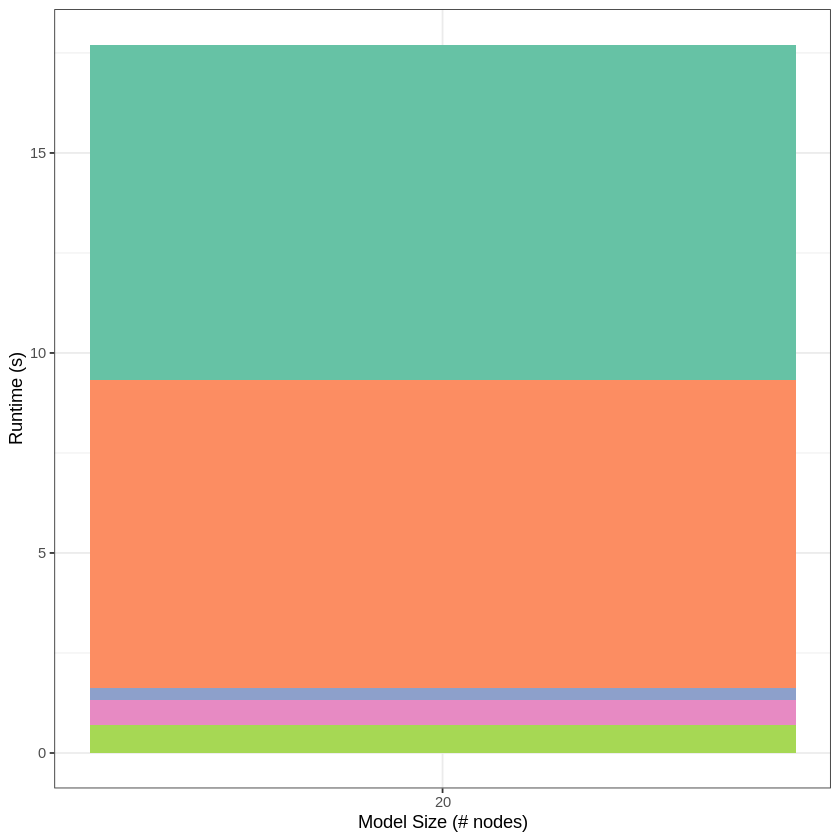

In [8]:
FamilyTreeRQ2Raw <- rbind(
#     Load10Log("measurements/stats/FamilyTree//size010to-1r10n10rt300nsdrealstats_06-0249.csv", 10),
    Load10Log("measurements2/stats/FamilyTree/size020to-1r10n10rt3600nsdreal-localstats_06-1949.csv", 20)
#     Load10Log("measurements1/stats1010.csv", 20),
#     Load10Log("measurements1/stats1515.csv", 30),
#     Load10Log("measurements1/stats2020.csv", 40),
#     Load10Log("measurements1/stats2525.csv", 50)
)
FamilyTreeRQ2Raw
FamilyTreeRQ2 <- FamilyTreeRQ2Raw %>% ProcessRQ2
FamilyTreeRQ2
median(FamilyTreeRQ2Raw$preprocessingTime) / 1000.0
FamilyTreeRQ2 %>% RQ2Plot('FamilyTree')